In [0]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, sparse_categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import figure
from skimage.io import imshow
from tensorflow.keras.layers import BatchNormalization

def unet(input_size = (2048,2048,4), filters=64, blocks=4):
    encoder = []
    inputs = Input(input_size)
    prev = inputs
    for i in range(blocks):
        cur = Conv2D(filters=filters, kernel_size=3, padding = 'same', kernel_initializer = 'he_normal')(prev)
        cur = BatchNormalization()(cur)
        cur = Activation(relu)(cur)

        cur = Conv2D(filters=filters, kernel_size=3, padding = 'same', kernel_initializer = 'he_normal')(cur)
        cur = BatchNormalization()(cur)
        cur = Activation(relu)(cur)

        encoder.append(cur)

        cur = MaxPooling2D()(cur)

        filters *= 2
        prev = cur

    for i in range(blocks - 1, -1, -1):
        cur = UpSampling2D()(prev)
        cur = Conv2D(filters=filters, kernel_size=3, padding='same')(cur)
        cur = Activation(relu)(cur)
        cur = concatenate([cur, encoder[i]], axis=3)

        cur = Conv2D(filters=filters, kernel_size=3, padding='same')(cur)
        cur = Activation(relu)(cur)
        cur = Conv2D(filters=filters, kernel_size=3, padding='same')(cur)
        cur = Activation(relu)(cur)

        prev = cur
        filters //= 2

    prev = Conv2D(1, kernel_size=1)(prev)
    prev = Activation(sigmoid)(prev)

    
    model = Model(inputs=inputs, outputs=prev)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model


Using TensorFlow backend.


In [0]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [0]:
import numpy as np 
import random as rnd
from matplotlib import pyplot as plt
from skimage.draw import circle
from skimage.io import imshow
from scipy.stats import poisson

def gen_gauss_dots(n_dots, xy_range, scale, mu=0, sigma=1, re_random=True):

    ''' xy_range: [[x_st, x_en], [y_st, y_en]] '''
    xy_range = np.array(xy_range).astype(np.int64)

    res = []
    for i in range(n_dots):
        res.append([rnd.gauss(mu, sigma), rnd.gauss(mu, sigma)])
    
    res = np.array(res)
    res *= scale
    res[:, 0] += xy_range[0].mean()
    res[:, 1] += xy_range[1].mean()
    res = res.astype(np.int64)

    if re_random:
        for i in range(res.shape[0]): 
            for j in range(2):
                if not (res[i, j] in range(xy_range[j, 0], xy_range[j, 1], 1)):
                    res[i, j] = np.random.randint(low=xy_range[j, 0], high=xy_range[j, 1], dtype=np.int64)
    else:
        res = [[x, y] for [x, y] in res if x in range(xy_range[0, 0], xy_range[0, 1], 1) and 
                                           y in range(xy_range[1, 0], xy_range[1, 1], 1)]
        res = np.array(res)
    
    return res

class Src: #добавить генерацию протяженного объекта

    def __init__(self, x, y, max_rad, max_n, noise=False):
        self.x = x
        self.y = y
        #self.rad = np.random.randint(2, max_rad + 1) #Poiss lambda - num ph 
        self.rad = max_rad
        self.n = poisson.rvs(mu=max_n)
        if noise:
            self.rad = max_rad
            self.n = max_n

    def gen_ph(self, label, scale=1, shape=None):
        xy_range = [[self.x - self.rad, self.x + self.rad + 1], 
                    [self.y - self.rad, self.y + self.rad + 1]]
        coords = gen_gauss_dots(self.n, xy_range, scale)
        if shape is not None:
            coords = np.array([[x, y] for [x, y] in coords 
                if x in range(shape[0]) and y in range(shape[1])])
        if coords.shape[0] == 0:
            return None

        labels = np.array([label] * len(coords)).reshape(len(coords), 1)
        return np.hstack([coords, labels])


def gen_src(n_src, max_rad, max_n, shape):
    coords = gen_gauss_dots(n_dots=n_src, xy_range=[[0, shape[0]], [0, shape[1]]], 
            scale=max(shape) * 4) 
    srcs = []
    for [x, y] in coords:
        srcs.append(Src(x, y, max_rad, max_n))
    return np.array(srcs)

def gen_ph_map(srcs, shape, n_noise):
    all_ph = None 
    for i in range(len(srcs)):
        ph = srcs[i].gen_ph(i, shape=shape)
        if not ph is None:
            if all_ph is None:
                all_ph = ph
            else:
               all_ph = np.vstack([all_ph, ph])
    
    noise = Src(shape[0] // 2, shape[1] // 2, max_rad = max(shape) * 4, max_n=n_noise, noise=True) 
    all_ph = np.vstack([all_ph, noise.gen_ph(len(srcs), scale=max(shape) * 440, shape=shape)])
    return all_ph

def gen_all(n_src, max_rad, max_n, shape, n_noise):
    srcs = gen_src(n_src, max_rad, max_n, shape)
    return gen_ph_map(srcs, shape, n_noise), srcs

def gen_train(n_src, max_rad, max_n, shape, d_noise):
    while 4:
        n_noise = int(d_noise * shape[0] * shape[1])
        phs, srcs = gen_all(n_src, max_rad, max_n, shape, n_noise)
        X = np.zeros(shape, np.uint8)
        Y = np.zeros(shape, np.uint8)
        phs = phs.astype(np.int64)
        for ph in phs:
            X[ph[0], ph[1], 0] = 1
        for src in srcs:
            c = circle(src.x, src.y, src.rad, shape)
            Y[c] = 1
        yield np.array([X]), np.array([Y])

rnd.seed(0)

In [0]:
input_size = (512, 512, 1)
#model = unet(input_size=input_size, filters=32, blocks=3)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


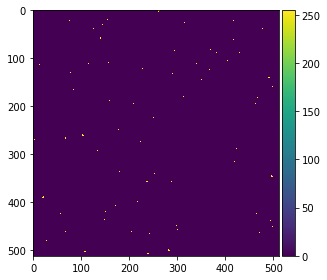

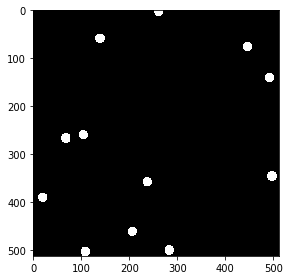

In [0]:
for X, Y in gen_train(n_src=12, max_rad=10, max_n=20, shape=input_size, d_noise=0.05):
    plt.figure(num=0)
    imshow(X[0, :, :, 0] * 255)
    plt.figure(num=1)
    imshow(Y[0, :, :, 0] * 255)
    plt.show()
    break


In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive


In [2]:
%cd cw
%ls

/gdrive/My Drive/cw
001000/      1.hdf5       2.png         do_png.py   __pycache__/
002036/      1.png        allwise_aux/  maps.txt    sources.txt
1000.simput  2036.simput  Area.py       model.hdf5  Unet.py


In [0]:
filepath='/gdrive/My Drive/cw/1.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)
callbacks_list = [checkpoint]

In [0]:
history = model.fit_generator(
    gen_train(n_src=50, max_rad=10, max_n=20, shape=input_size, d_noise=0.05),
    steps_per_epoch = 2,
    epochs=500, callbacks=callbacks_list)

Epoch 1/500
1/2 [==============>...............] - ETA: 56s - loss: 0.1226 - acc: 0.9438
Epoch 00001: loss improved from inf to 0.11915, saving model to /gdrive/My Drive/cw/1.hdf5
2/2 [==============================] - 108s 54s/step - loss: 0.1191 - acc: 0.9435
Epoch 2/500
1/2 [==============>...............] - ETA: 47s - loss: 0.1060 - acc: 0.9469
Epoch 00002: loss improved from 0.11915 to 0.10131, saving model to /gdrive/My Drive/cw/1.hdf5
2/2 [==============================] - 99s 50s/step - loss: 0.1013 - acc: 0.9496
Epoch 3/500
1/2 [==============>...............] - ETA: 48s - loss: 0.0934 - acc: 0.9564
Epoch 00003: loss improved from 0.10131 to 0.08633, saving model to /gdrive/My Drive/cw/1.hdf5
2/2 [==============================] - 83s 41s/step - loss: 0.0863 - acc: 0.9599
Epoch 4/500
1/2 [==============>...............] - ETA: 27s - loss: 0.0737 - acc: 0.9688
Epoch 00004: loss improved from 0.08633 to 0.07154, saving model to /gdrive/My Drive/cw/1.hdf5
2/2 [===================

In [0]:
history = model.fit_generator(
    gen_train(n_src=50, max_rad=10, max_n=20, shape=input_size, d_noise=0.05),
    steps_per_epoch = 10,
    epochs=500, callbacks=callbacks_list)

In [3]:
from tensorflow.keras.models import load_model
model = load_model('1.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


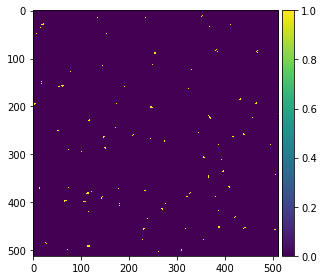

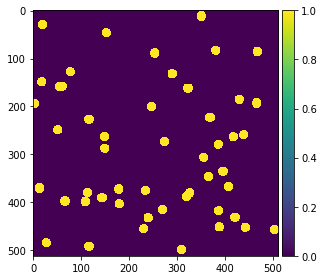

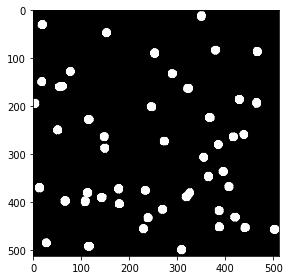

In [8]:
for x, y in gen_train(n_src=50, max_rad=10, max_n=20, shape=input_size, d_noise=0.05):
    ans = model.predict(x)
    plt.figure(0)
    imshow(x[0, :, :, 0])
    plt.figure(1)
    imshow(y[0, :, :, 0])
    plt.figure(2)
    imshow(ans[0, :, :, 0])
    plt.show()
    break